In [2]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.optim as optim

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time


cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [3]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512 # encoder dim
h_P_dim = 512 # decoder dim

c = 0 # unsure of this constant
lr = 1e-4 # learning rate

# problem dimenc_dimsions
dim = 6 # (x, y, yaw, steer, xdot, ydot)
dataElements = dim+3*3+2*dim+3 # sample (6D), gap1 (2D, 1D orientation), gap2, gap3, init (5D), goal (5D), current state (3D)

z_dim = 3 # latent dim
X_dim = dim # samples dim
y_dim = dim # reconstruction of the original point (unsused?)
c_dim = dataElements - dim # dimension of conditioning variable

In [4]:
# read in data from csv
filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/motion_planning/pathDataWhole'
data = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=range(28))

numEntries = data.shape[0]

In [5]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain,0:dim] # samples state: x, y, yaw, steer, xdot, ydot
c_train = data[0:numTrain,dim:dataElements] # conditions: gaps, init (4), goal (4)

X_test = data[numTrain:numEntries,0:dim]
c_test = data[numTrain:numEntries,dim:dataElements]
numTest = X_test.shape[0]

In [6]:
# change conditions to occupancy grid
def isSampleFree(sample, obs):
    for o in list(range(0,obs.shape[0]//(2*dimW))): # python 2 -> 3: use list(), use //
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

gridSize = 11
dimW = 3
plotOn = False;

# process data into occupancy grid
conditions = data[0:numEntries,dim:dataElements]
conditionsOcc = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0;
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1;

start = time.time();
for j in range(0,numEntries,1):
    dw = 0.1
    dimW = 3
    gap1 = conditions[j,0:3]
    gap2 = conditions[j,3:6]
    gap3 = conditions[j,6:9]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 5000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    conditionsOcc[j,:] = occGrid
    
end = time.time();
print('Time: ', end-start)
    
cs = np.concatenate((conditionsOcc, data[0:numEntries,dim+3*dimW:dataElements]), axis=1) # occ(11x11), init (6D), goal (6D), current (3D) 
c_dim = cs.shape[1]
c_gapsInitGoal = c_test
c_train = cs[0:numTrain,:] 
c_test = cs[numTrain:numEntries,:]

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000
Iter: 30000
Iter: 35000
Iter: 40000
Iter: 45000
Iter: 50000
Iter: 55000
Iter: 60000
Iter: 65000
Iter: 70000
Iter: 75000
Iter: 80000
Iter: 85000
Time:  31.567542552947998


In [7]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:
            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))
            
            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y


encoder = Encoder()
decoder = Decoder()
network = NeuralNetwork(Encoder=encoder, Decoder=decoder).to(DEVICE)

weight = torch.tensor([1, 1, 0.5, 1.0, 0.5, 0.5], requires_grad=False, dtype=torch.float32, device=DEVICE)

def loss_function(x, y, mean, logvar):
    recon_loss = (weight * (x - y) ** 2).mean()
    kl_loss    = 10**-4 * 2 * torch.sum(torch.exp(logvar) + mean.pow(2) - 1. - logvar, dim=1)

    return torch.mean(kl_loss + recon_loss)

optimizer = optim.Adam(network.parameters(), lr=lr)

#network = torch.load('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_distributions/network1.pt')

In [41]:
# Training
for it in range(500001):
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]

    X_mb = torch.tensor(X_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)
    c_mb = torch.tensor(c_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)

    optimizer.zero_grad()

    y, z_mu, z_logvar = network(X_mb, c_mb)
    
    loss = loss_function(X_mb, y, z_mu, z_logvar)
    loss.backward()
    optimizer.step()

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()


Iter: 0
Loss: 0.6463

Iter: 1000
Loss: 0.02408

Iter: 2000
Loss: 0.01986

Iter: 3000
Loss: 0.0175

Iter: 4000
Loss: 0.01478

Iter: 5000
Loss: 0.01256

Iter: 6000
Loss: 0.01095

Iter: 7000
Loss: 0.00994

Iter: 8000
Loss: 0.009902

Iter: 9000
Loss: 0.009902

Iter: 10000
Loss: 0.008609

Iter: 11000
Loss: 0.008004

Iter: 12000
Loss: 0.007519

Iter: 13000
Loss: 0.007686

Iter: 14000
Loss: 0.008927

Iter: 15000
Loss: 0.007292

Iter: 16000
Loss: 0.006588

Iter: 17000
Loss: 0.006762

Iter: 18000
Loss: 0.007088

Iter: 19000
Loss: 0.006284

Iter: 20000
Loss: 0.006254

Iter: 21000
Loss: 0.005433

Iter: 22000
Loss: 0.005895

Iter: 23000
Loss: 0.007326

Iter: 24000
Loss: 0.005721

Iter: 25000
Loss: 0.00599

Iter: 26000
Loss: 0.006086

Iter: 27000
Loss: 0.005567

Iter: 28000
Loss: 0.006001

Iter: 29000
Loss: 0.006489

Iter: 30000
Loss: 0.005484

Iter: 31000
Loss: 0.006186

Iter: 32000
Loss: 0.005413

Iter: 33000
Loss: 0.006241

Iter: 34000
Loss: 0.00603

Iter: 35000
Loss: 0.005826

Iter: 36000
Loss:

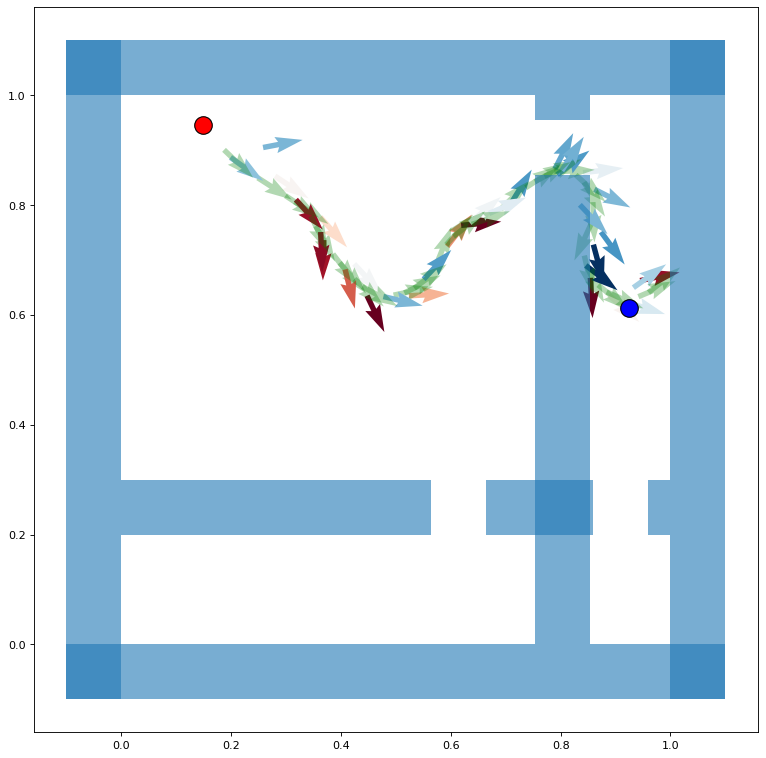

In [22]:
# plot the latent space

fig1 = plt.figure(figsize=(20,12), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

num_viz = 1 # number of samples to draw in latent space
_, pathInd = np.unique(c_test[:,gridSize*gridSize], return_index=True)
vizIdx = np.random.choice(pathInd) # chose a random test scenario

i = vizIdx
while True:

    c_sample_seed = c_test[i,:]
    c_sample = torch.from_numpy(np.repeat([c_sample_seed],num_viz,axis=0)).float().to(DEVICE)
    c_viz = c_gapsInitGoal[i,:]
    currState = c_viz[19:]

    # directly sample from the latent space (preferred, what we will use in the end)
    y_viz = network(torch.randn(num_viz, z_dim).to(DEVICE), c_sample, encode=False).cpu().detach().numpy()

    ax1.quiver(y_viz[:,0], y_viz[:,1], np.cos(y_viz[:,2]), np.sin(y_viz[:,2]), y_viz[:,3], norm=Normalize(vmin=-np.pi/2, vmax=np.pi/2, clip=True), cmap='RdBu') # steer right -> Blue, steer left -> Red
    ax1.quiver(currState[0], currState[1], np.cos(currState[2])/3, np.sin(currState[2])/3, color="green", alpha=0.3)

    i+=1
    if not c_test[i,gridSize*gridSize] == c_test[vizIdx,gridSize*gridSize]: # if the path ends
        break

dw = 0.1
dimW = 3
gap1 = c_viz[0:3]
gap2 = c_viz[3:6]
gap3 = c_viz[6:9]
init = c_viz[9:14]
goal = c_viz[14:19]

obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
obsBounds = [-0.1, -0.1, -0.5, 0, 1.1, 1.5,
            -0.1, -0.1, -0.5, 1.1, 0, 1.5,
            -0.1, 1, -0.5, 1.1, 1.1, 1.5,
            1, -0.1, -0.5, 1.1, 1.1, 1.5,]

obs = np.concatenate((obs1, obs2, obs3, obs4, obs5, obsBounds), axis=0)
for i in list(range(0,obs.shape[0]//(2*dimW))): # list() and //
    ax1.add_patch(
    patches.Rectangle(
        (obs[i*2*dimW], obs[i*2*dimW+1]),   # (x,y)
        obs[i*2*dimW+dimW] - obs[i*2*dimW],          # width
        obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1],          # height
        alpha=0.6
    ))

ax1.scatter(init[0], init[1], color="red", s=250, edgecolors='black') # init
ax1.scatter(goal[0], goal[1], color="blue", s=250, edgecolors='black') # goal

plt.show()



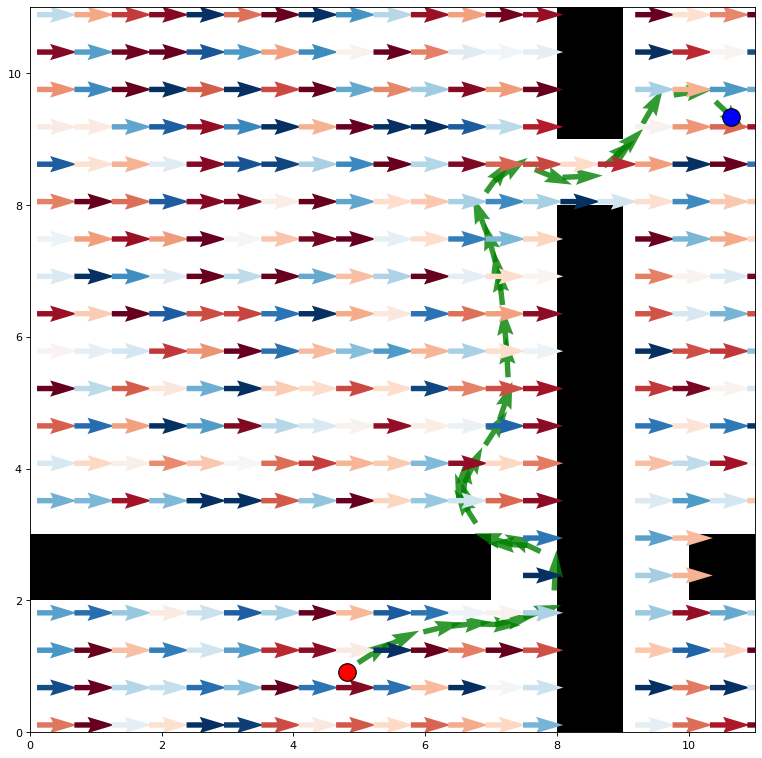

In [10]:
# plot the latent space

fig1 = plt.figure(figsize=(20,12), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

num_viz = 1 # number of samples to draw in latent space
_, pathInd = np.unique(c_test[:,gridSize*gridSize], return_index=True)
vizIdx = np.random.choice(pathInd) # chose a random test scenario

dimW = 3

i = vizIdx
while True:
    c_viz = c_gapsInitGoal[i,:]
    currState = c_viz[19:]

    ax1.quiver(currState[0]*gridSize, currState[1]*gridSize, np.cos(currState[2])/3, np.sin(currState[2])/3, color="green", alpha=0.8)

    i+=1
    if not c_test[i,gridSize*gridSize] == c_test[vizIdx,gridSize*gridSize]: # if the path ends
        break

c = c_test[vizIdx, :]
grid = np.rot90(c[:gridSize*gridSize].reshape(gridSize,gridSize))
xv, yv = np.meshgrid(np.linspace(0.01, 0.99, 20), np.linspace(0.01, 0.99, 20), indexing='ij')

for x, y in zip(xv.reshape(-1),yv.reshape(-1)):

    u = int(np.floor(x * grid.shape[1])) # right pointing image axis
    v = int(np.floor(grid.shape[0] * (1 - y))) # down pointing image axis

    if grid[v,u] > 0:
        cyaw = 0
        c[-3:] = [x, y, cyaw] # constant yaw
        c_tensor = torch.from_numpy(c.reshape(1,c.shape[0])).float().to(DEVICE)
        y_viz = network(torch.randn(1, z_dim).to(DEVICE), c_tensor, encode=False).cpu().detach().numpy()

        ax1.quiver(x*gridSize, y*gridSize, np.cos(cyaw), np.sin(cyaw), y_viz[:,3], norm=Normalize(vmin=-np.pi/2, vmax=np.pi/2, clip=True), cmap='RdBu') # steer right -> Blue, steer left -> Red

init = c_viz[9:14]
goal = c_viz[14:19]

ax1.scatter(init[0]*gridSize, init[1]*gridSize, color="red", s=250, edgecolors='black') # init
ax1.scatter(goal[0]*gridSize, goal[1]*gridSize, color="blue", s=250, edgecolors='black') # goal
ax1.imshow(grid, extent=[0, gridSize, 0, gridSize], cmap='gray')

# plt.show()
